# Useful references

## Python + Numpy + Matplotlib + etc.

* Python Numpy Tutorial: http://cs231n.github.io/python-numpy-tutorial/
* Computational Statistics in Python: https://people.duke.edu/~ccc14/sta-663/
* Numpy for MATLAB users: https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
* MATLAB synonymous commands in Python/NumPy: http://mathesaurus.sourceforge.net/

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html



# 1. Current clamp simulation on a passive pyramidal neuron

Here we demonstrate how to run a current clamp simulation with a passive pyramidal neuron for the second home work. First, we begin by importing NEURON and another module `r18_1`, which constructs a pyramidal cell:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import r18_1

Inserting passive membrane properties

Initializing uniform passive membrane properties



Here we load a session file for the virtual current clamp experiment:

In [3]:
h.xopen("iclamp.ses")

1.0

Loading this session embeds a current clamp electrode `h.IClamp[0]`, whose parameters are:

In [4]:
print('Activation onset = {} ms\nDuration = {} ms\nAmplitude = {} nA'.format(
        h.IClamp[0].delay, h.IClamp[0].dur, h.IClamp[0].amp))

Activation onset = 50.0 ms
Duration = 150.0 ms
Amplitude = 0.1 nA


You can control the location and parameters via the "PointProcessManager" window. Now let's run simulation while recording the membrane potential at soma.

In [5]:
def run(tstop=200):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    vrec = h.Vector() # The recording will be save in this vector
    vrec.record(h.soma(0.5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return vrec.c() # Should return a copy of the vector


Let's collect multiple recordings in a list and also make a note of where the electrode was:

In [6]:
# Reset lists
vrecs = []
distances = []

In [12]:
vrecs.append(run())
# r18_1.distance_from_soma(ic) computes a distance from a soma 
# to the current clamp electrode
distances.append(r18_1.distance_from_soma(h.IClamp[0]))

print("Number of simulations ran =", len(distances))

Number of simulations ran = 6


<IPython.core.display.Javascript object>


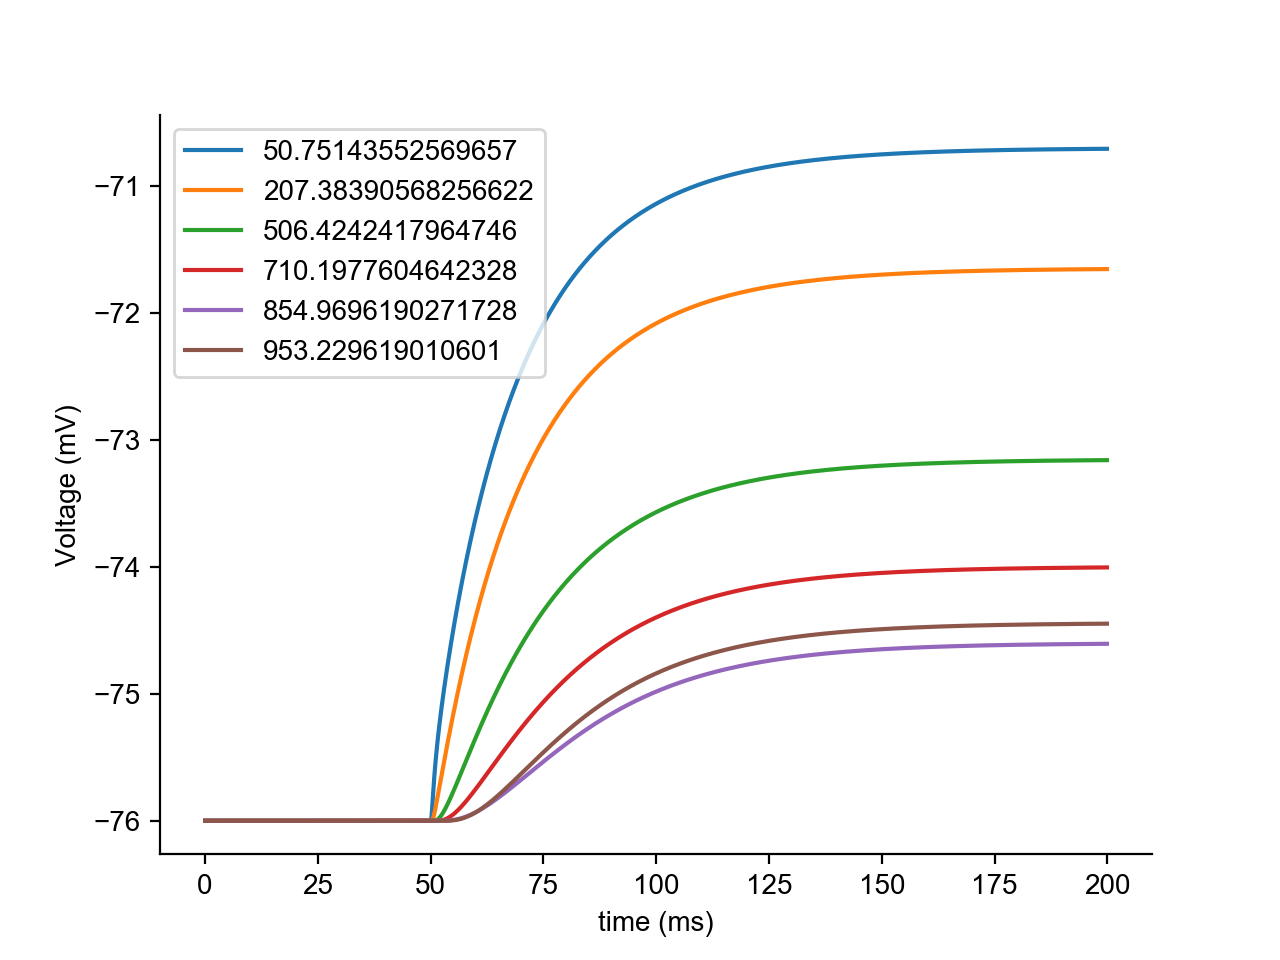

[Text(0,0.5,'Voltage (mV)'), Text(0.5,0,'time (ms)')]

In [13]:
%matplotlib nbagg

fig,ax = plt.subplots()
t = np.arange(2000)*0.1
for v in vrecs:
    ax.plot(t, v)
ax.legend(distances)
ax.set(xlabel='time (ms)', ylabel='Voltage (mV)')

# Building a network

Network construction in NEURON follows the following steps:

1. Prepare neurons (morphology, mechanisms, etc.) and external stimuli if necessary,
2. Embed synapse objects in each neuron,
3. Connect the neurons to the synapses via [NetCon](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html),
4. Set up recordings,
5. Run the simulation.

![](./imgs/net_construction.png)


Here we demonstrate two simple networks with one pyramidal neuron and one or two external stimuli.

## 2. 1 Pyramidal cell + 1 stimulus

Again, we start from importing the NEURON and cell module (**be sure to restart the kernel before this**)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import r18_1

Inserting passive membrane properties

Initializing uniform passive membrane properties



Here we open a session that embeds a synapse object called [Exp2Syn](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=exp2syn#Exp2Syn).

In [2]:
h.xopen("one_syn.ses")

1.0

In [3]:
print('tau1 = {} ms\ntau2 = {} ms'.format(
        h.Exp2Syn[0].tau1, h.Exp2Syn[0].tau2))

tau1 = 0.1 ms
tau2 = 2.0 ms


Again we define our run function:

In [4]:
def run(tstop=250):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    vrec = h.Vector() # The recording will be save in this vector
    vrec.record(h.soma(0.5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return vrec.c() # Should return a copy of the vector

However, nothing happens during our simulation since there is no input connected to the synapse.

<IPython.core.display.Javascript object>


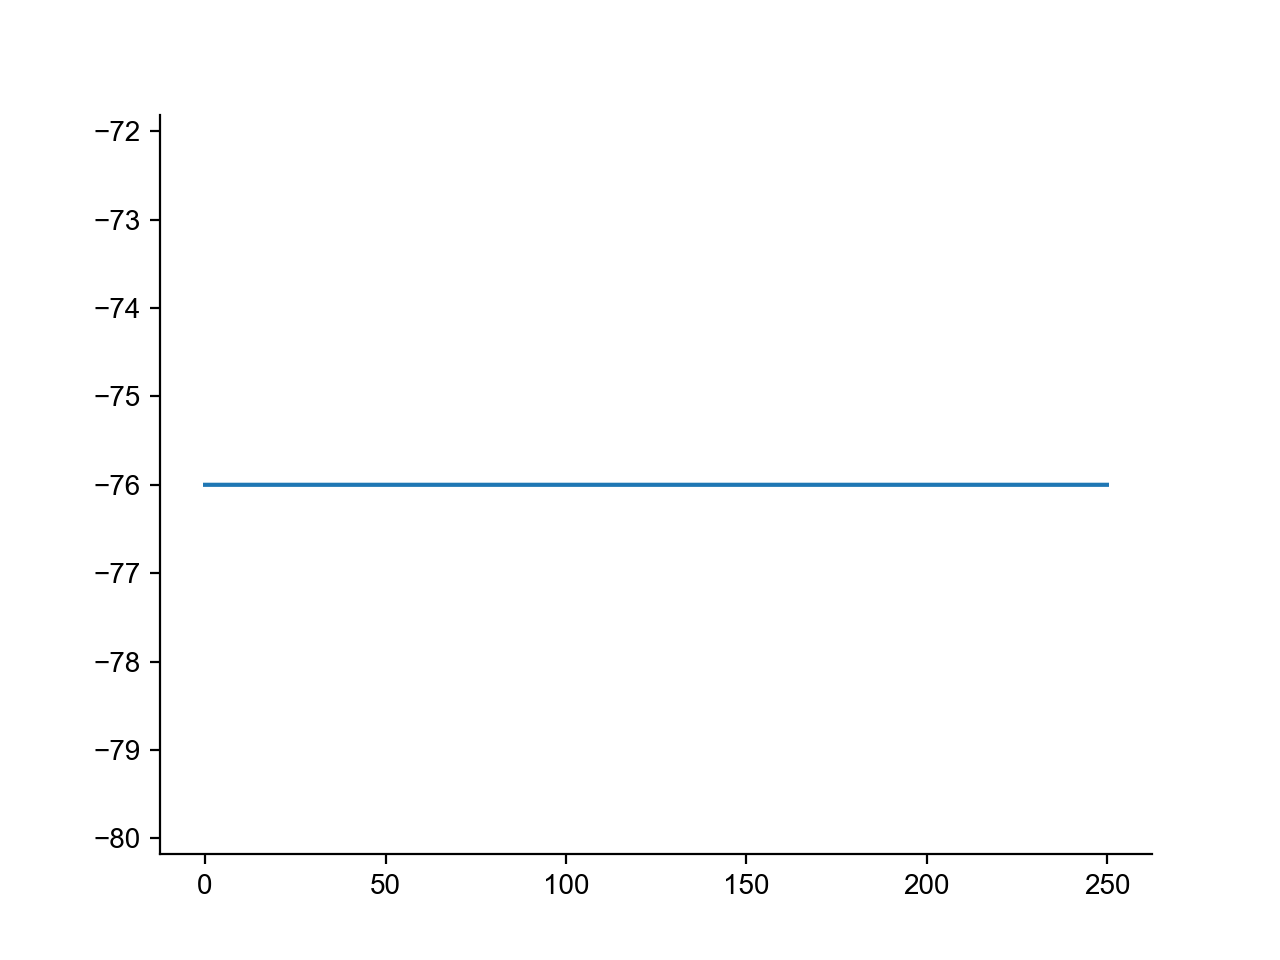

In [5]:
%matplotlib notebook
vrec = run()

fig, ax = plt.subplots()
ax.plot(np.arange(2500)*0.1, vrec)

Therefore, we prepare an artificial spike generator called [NetStim](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=netstim#NetStim) and connect this to `h.Exp2Syn[0]` by a `NetCon` object.

In [6]:
# Check out the documentation for what the parameters are
stim = h.NetStim()
stim.start = 50
stim.number = 1
stim.noise = 0

# Connect stim to our synapse
nc = h.NetCon(stim, h.Exp2Syn[0])

Nothing happens yet since the synaptic conductance is 0. We set this to a non-zero value:

In [7]:
nc.weight[0] = 0.01 # 0.01 nS = 10 pS of the synaptic conductance

<IPython.core.display.Javascript object>


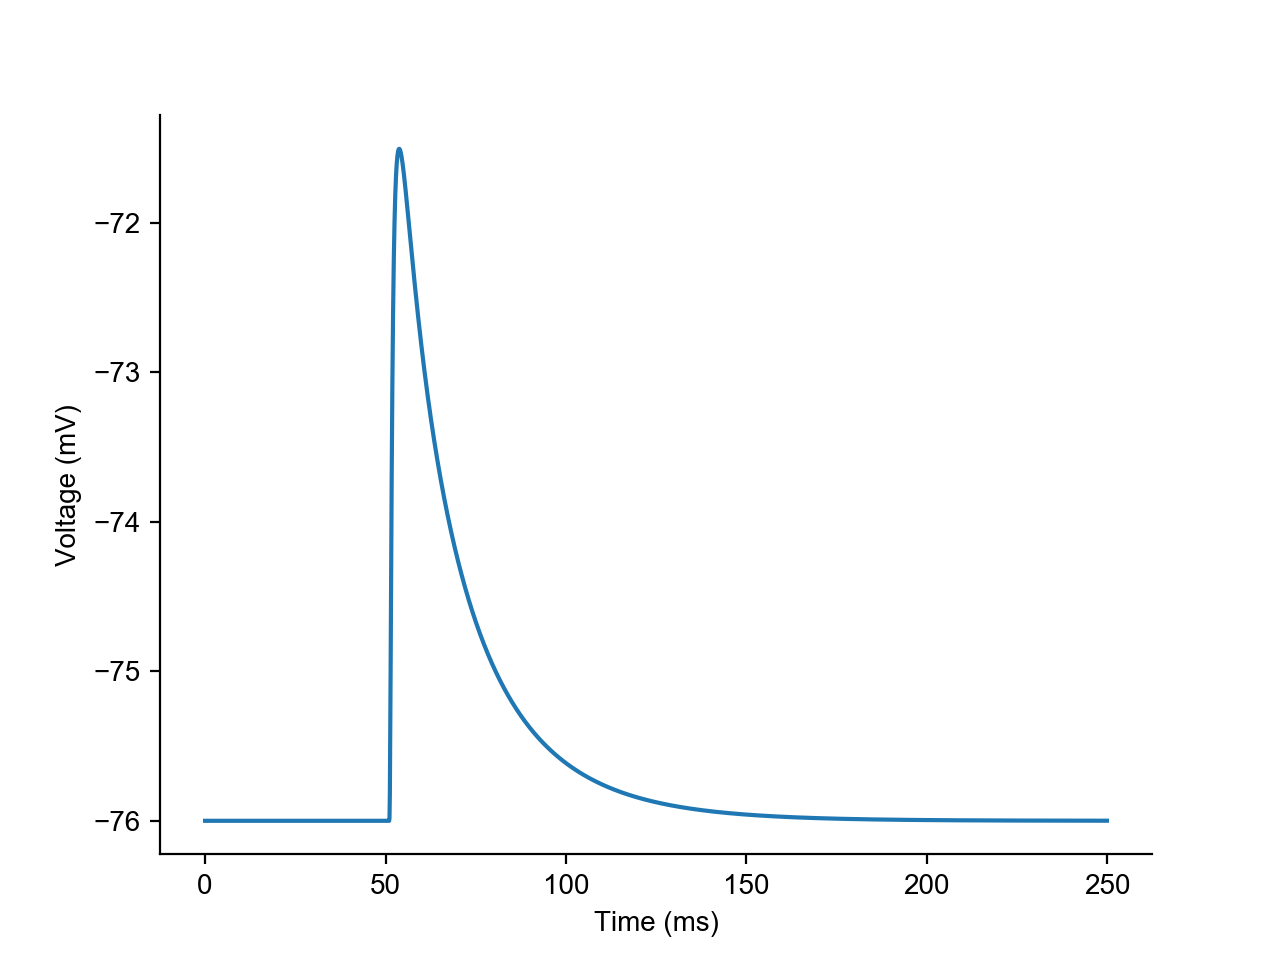

[Text(0,0.5,'Voltage (mV)'), Text(0.5,0,'Time (ms)')]

In [8]:
vrec = run()

fig, ax = plt.subplots()
t = np.arange(vrec.size())*0.1
ax.plot(t, vrec)
ax.set(xlabel="Time (ms)", ylabel="Voltage (mV)")

Now we see an EPSP triggered by a spike from `stim`.

## 1 Pyramidal cell + 2 stimuli

Again, we start from importing the NEURON and cell module **after restarting the kernel**:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
import r18_1

Inserting passive membrane properties

Initializing uniform passive membrane properties



We import a session with two synapses, `h.Exp2Syn[0]` and `h.Exp2Syn[1]`.

In [2]:
h.xopen("two_syns.ses")

1.0

Here we put the spike generators and NetCons in lists:

In [3]:
stim = []
nc = []
for i in range(2):
    stim.append(h.NetStim())
    stim[i].start = 50
    stim[i].number = 1
    stim[i].noise = 0
    
    nc.append(h.NetCon(stim[i], h.Exp2Syn[i]))
    nc[i].weight[0] = 0.01

In [5]:
def run(tstop=250):
    """runs a simulation and returns the membrane potential recording at the soma."""
    dt = 0.1 # Again we use 10kHz sampling rate, e.g. 0.1 ms interval
    vrec = h.Vector() # The recording will be save in this vector
    vrec.record(h.soma(0.5)._ref_v, dt)
    
    h.tstop = tstop  # Set how long the simulation will run.
    h.init()
    h.run()
    
    return vrec.c() # Should return a copy of the vector

<IPython.core.display.Javascript object>


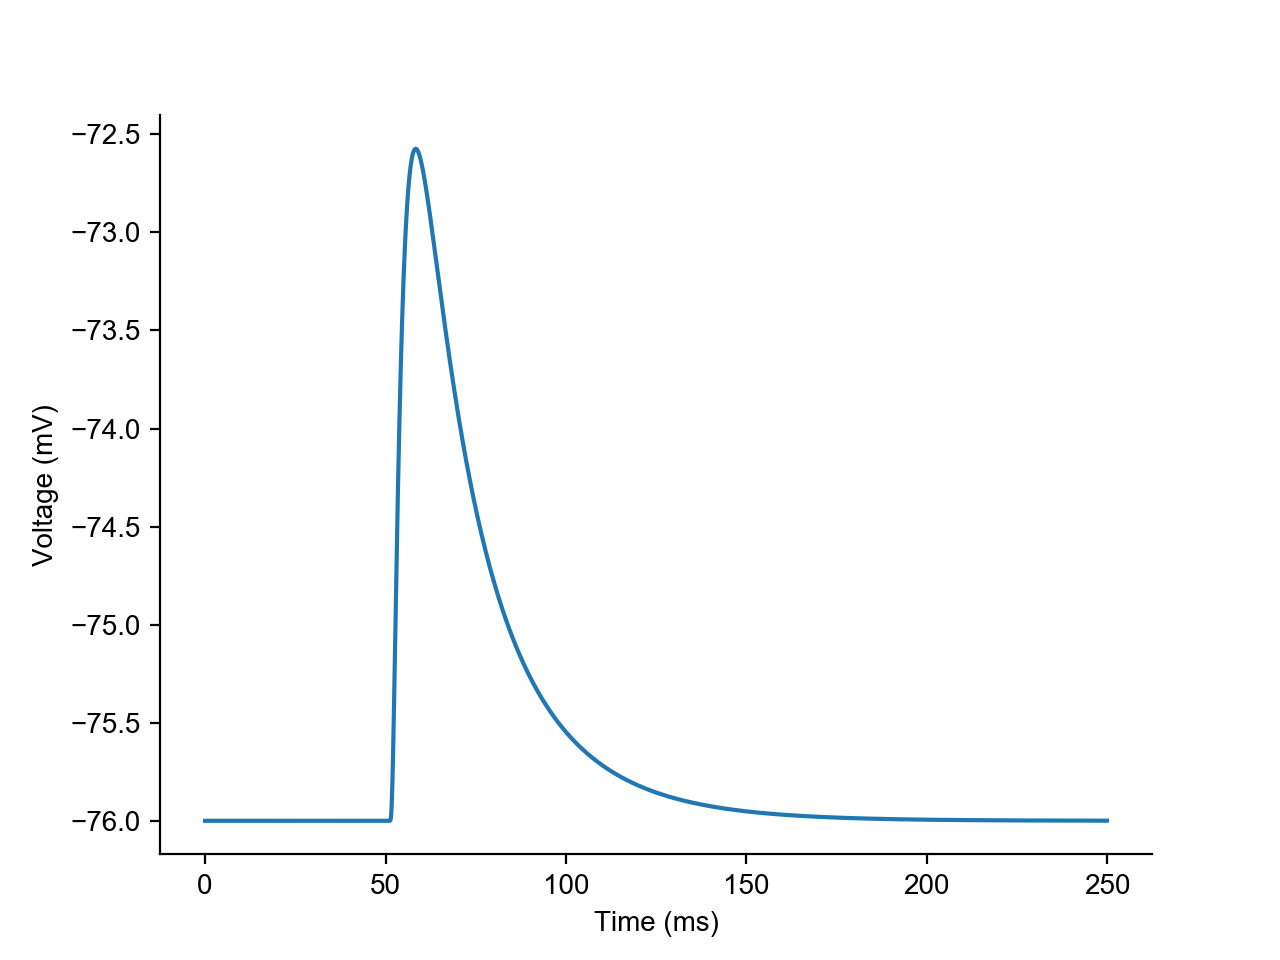

[Text(0,0.5,'Voltage (mV)'), Text(0.5,0,'Time (ms)')]

In [6]:
%matplotlib notebook

vrec = run()

fig, ax = plt.subplots()
t = np.arange(vrec.size())*0.1
ax.plot(t, vrec)
ax.set(xlabel="Time (ms)", ylabel="Voltage (mV)")

Here we move the second synapse close to the first, make it inhibitory, slow decaying, and early activating:

In [7]:
r18_1.move_electrode_to(h.Exp2Syn[1], h.dend1[859](0.5))
h.Exp2Syn[1].e = -76
h.Exp2Syn[1].tau2 = 100
stim[1].start = 0

<IPython.core.display.Javascript object>


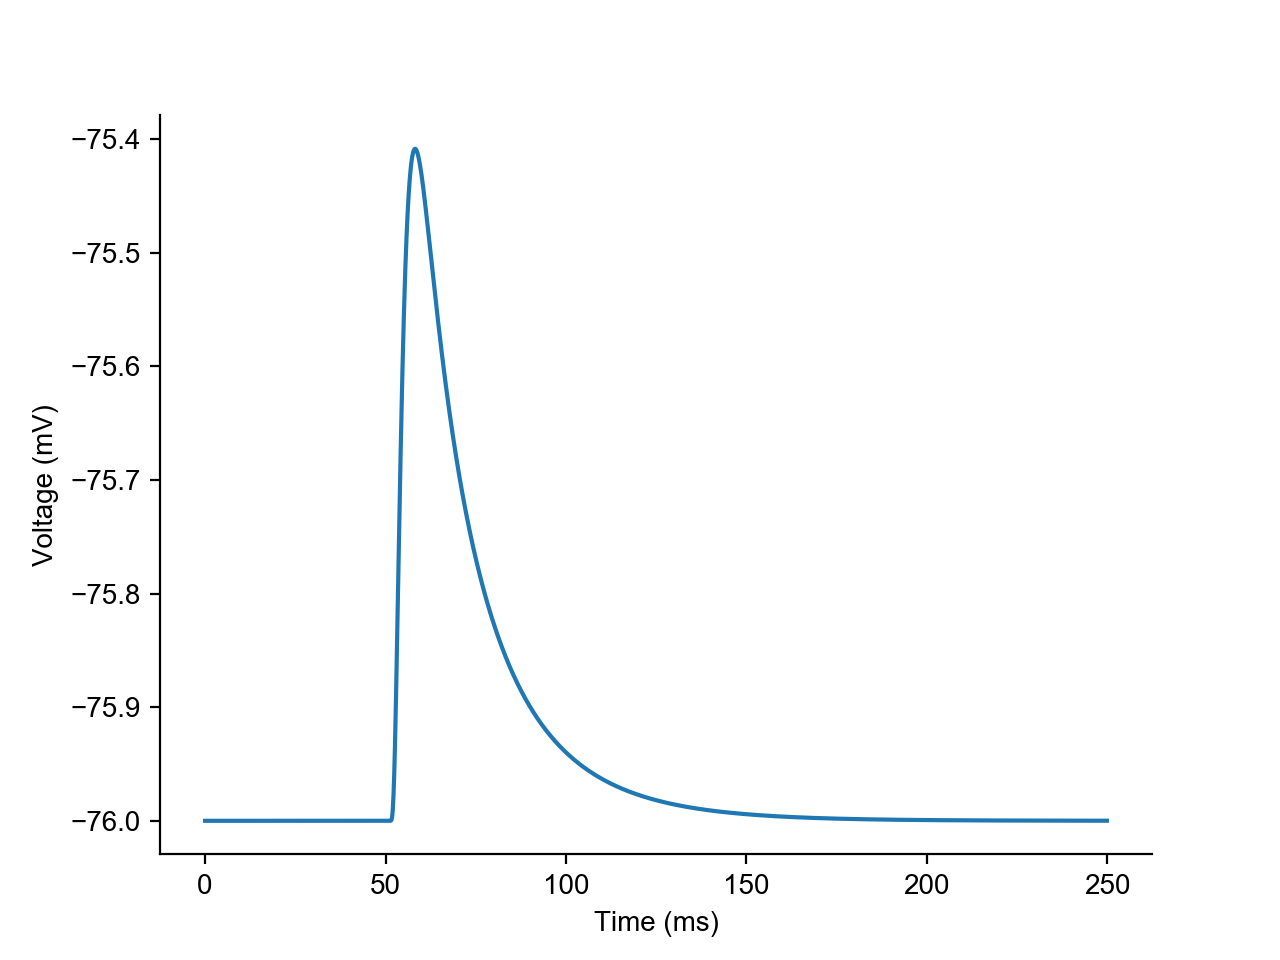

[Text(0,0.5,'Voltage (mV)'), Text(0.5,0,'Time (ms)')]

In [8]:
vrec = run()

fig, ax = plt.subplots()
t = np.arange(vrec.size())*0.1
ax.plot(t, vrec)
ax.set(xlabel="Time (ms)", ylabel="Voltage (mV)")

Note that the EPSP amplitude decreased due to *shunting* by the inhibitory synapse.